In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
from run_simulation import invasion_main

In [2]:
simulation_df = invasion_main(10)
# print(type(simulation_df))
simulation_df

,County,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10
0,Cook,0.1,5.659005e-02,3.614460e-02,2.402725e-02,0.016804,0.011931,0.009078,0.006031,0.004060,0.002792,0.001978
1,DuPage,0.0,2.224685e-02,2.570154e-02,2.202642e-02,0.014395,0.010644,0.008474,0.006266,0.003825,0.002744,0.001834
2,Kane,0.3,1.543560e-01,8.253709e-02,4.606973e-02,0.026672,0.016300,0.010669,0.006787,0.004482,0.003246,0.002292
3,Will,0.0,1.646278e-02,1.467241e-02,1.310739e-02,0.010007,0.007929,0.006062,0.004345,0.003053,0.002041,0.001549
4,Winnebago,0.0,6.895011e-02,7.031263e-02,5.525773e-02,0.040010,0.031534,0.023264,0.016154,0.010684,0.006950,0.004301
...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,1.470000e-06,4.640000e-06,1.527000e-05,0.000032,0.000048,0.000058,0.000055,0.000046,0.000050,0.000050
98,Calhoun,0.0,1.336650e-03,2.172130e-03,2.238870e-03,0.002040,0.001881,0.001713,0.001294,0.000952,0.000691,0.000461
99,Schuyler,0.0,3.400000e-07,3.640000e-06,1.338000e-05,0.000024,0.000033,0.000042,0.000047,0.000047,0.000046,0.000044
100,Gallatin,0.0,7.000000e-08,7.400000e-07,1.300000e-06,0.000003,0.000006,0.000008,0.000009,0.000009,0.000010,0.000011


In [3]:
visual_df = simulation_df.T
visual_df.columns = visual_df.iloc[0]
visual_df = visual_df.drop(visual_df.index[0])
visual_df

County,Cook,DuPage,Kane,Will,Winnebago,Lake,McHenry,St. Clair,Kendall,Madison,...,Scott,Stark,Jasper,Hamilton,Pike,Henderson,Calhoun,Schuyler,Gallatin,Pope
Week 0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Week 1,0.05659,0.022247,0.154356,0.016463,0.06895,0.010655,0.013122,0.020318,0.016171,0.251026,...,0.000089,0.00007,0.000005,0.000001,0.000027,0.000001,0.001337,0.0,0.0,0.0
Week 2,0.036145,0.025702,0.082537,0.014672,0.070313,0.009881,0.016425,0.021031,0.014133,0.13032,...,0.00023,0.000165,0.000095,0.00001,0.000143,0.000005,0.002172,0.000004,0.000001,0.0
Week 3,0.024027,0.022026,0.04607,0.013107,0.055258,0.007586,0.015127,0.021325,0.0129,0.069358,...,0.000463,0.00027,0.000195,0.000018,0.000247,0.000015,0.002239,0.000013,0.000001,0.0
Week 4,0.016804,0.014395,0.026672,0.010007,0.04001,0.007152,0.012819,0.015414,0.010783,0.037917,...,0.000423,0.000317,0.00024,0.000032,0.000316,0.000032,0.00204,0.000024,0.000003,0.000003
Week 5,0.011931,0.010644,0.0163,0.007929,0.031534,0.00681,0.009231,0.01035,0.008259,0.020932,...,0.000512,0.000377,0.000258,0.000041,0.000392,0.000048,0.001881,0.000033,0.000006,0.000003
Week 6,0.009078,0.008474,0.010669,0.006062,0.023264,0.004918,0.006961,0.007278,0.006006,0.012338,...,0.000519,0.000362,0.000267,0.000047,0.000393,0.000058,0.001713,0.000042,0.000008,0.000003
Week 7,0.006031,0.006266,0.006787,0.004345,0.016154,0.003688,0.005127,0.004496,0.004706,0.00742,...,0.000419,0.00032,0.000255,0.000045,0.000342,0.000055,0.001294,0.000047,0.000009,0.000003
Week 8,0.00406,0.003825,0.004482,0.003053,0.010684,0.002865,0.003674,0.002871,0.003348,0.004659,...,0.000343,0.000309,0.000217,0.000051,0.000299,0.000046,0.000952,0.000047,0.000009,0.000006
Week 9,0.002792,0.002744,0.003246,0.002041,0.00695,0.001867,0.002637,0.001752,0.002366,0.002922,...,0.000278,0.000258,0.000186,0.000045,0.000246,0.00005,0.000691,0.000046,0.00001,0.000006


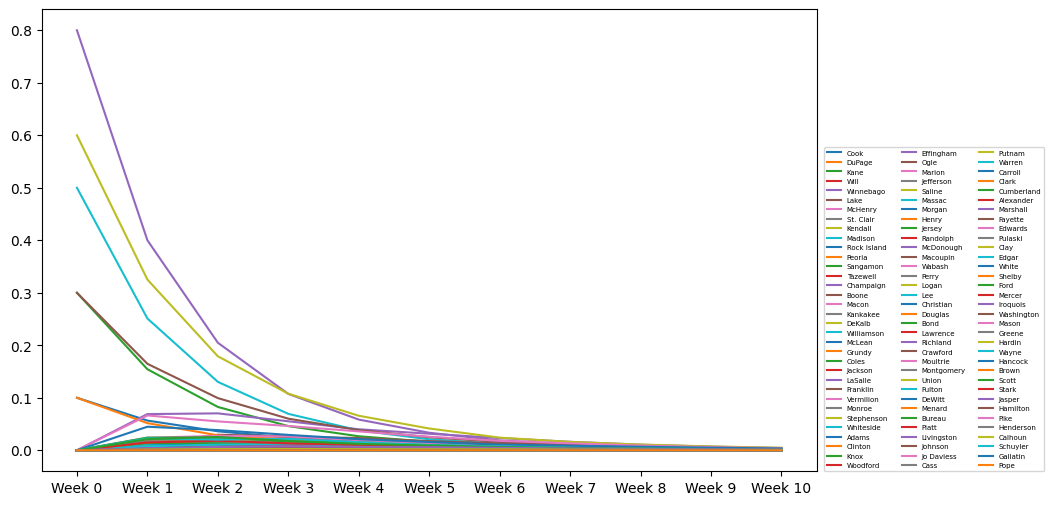

In [4]:
plt.figure(figsize=(10,6))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=5, ncol=3)
plt.show()

In [5]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [6]:
min_value = simulation_df['Week 0'].min()
max_value = simulation_df['Week 0'].max()
cmap = matplotlib.colormaps['viridis']

node_colors = {}
for node in CG.nodes():
    if node.name in simulation_df['County'].values:
        value = simulation_df.loc[simulation_df['County'] == node.name, 'Week 0'].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)
    else:
        # Handle nodes not present in the DataFrame (optional: set a default color)
        node_colors[node.name] = 'gray'  # or any other color for nodes not in the DataFrame

print(node_colors)

{'Cook': (0.278826, 0.17549, 0.483397, 1.0), 'DuPage': (0.267004, 0.004874, 0.329415, 1.0), 'Kane': (0.174274, 0.445044, 0.557792, 1.0), 'Will': (0.267004, 0.004874, 0.329415, 1.0), 'Winnebago': (0.267004, 0.004874, 0.329415, 1.0), 'Lake': (0.267004, 0.004874, 0.329415, 1.0), 'McHenry': (0.267004, 0.004874, 0.329415, 1.0), 'St. Clair': (0.267004, 0.004874, 0.329415, 1.0), 'Kendall': (0.267004, 0.004874, 0.329415, 1.0), 'Madison': (0.157851, 0.683765, 0.501686, 1.0), 'Rock Island': (0.267004, 0.004874, 0.329415, 1.0), 'Peoria': (0.267004, 0.004874, 0.329415, 1.0), 'Sangamon': (0.267004, 0.004874, 0.329415, 1.0), 'Tazewell': (0.267004, 0.004874, 0.329415, 1.0), 'Champaign': (0.993248, 0.906157, 0.143936, 1.0), 'Boone': (0.267004, 0.004874, 0.329415, 1.0), 'Macon': (0.267004, 0.004874, 0.329415, 1.0), 'Kankakee': (0.267004, 0.004874, 0.329415, 1.0), 'DeKalb': (0.267004, 0.004874, 0.329415, 1.0), 'Williamson': (0.267004, 0.004874, 0.329415, 1.0), 'McLean': (0.267004, 0.004874, 0.329415, 1.

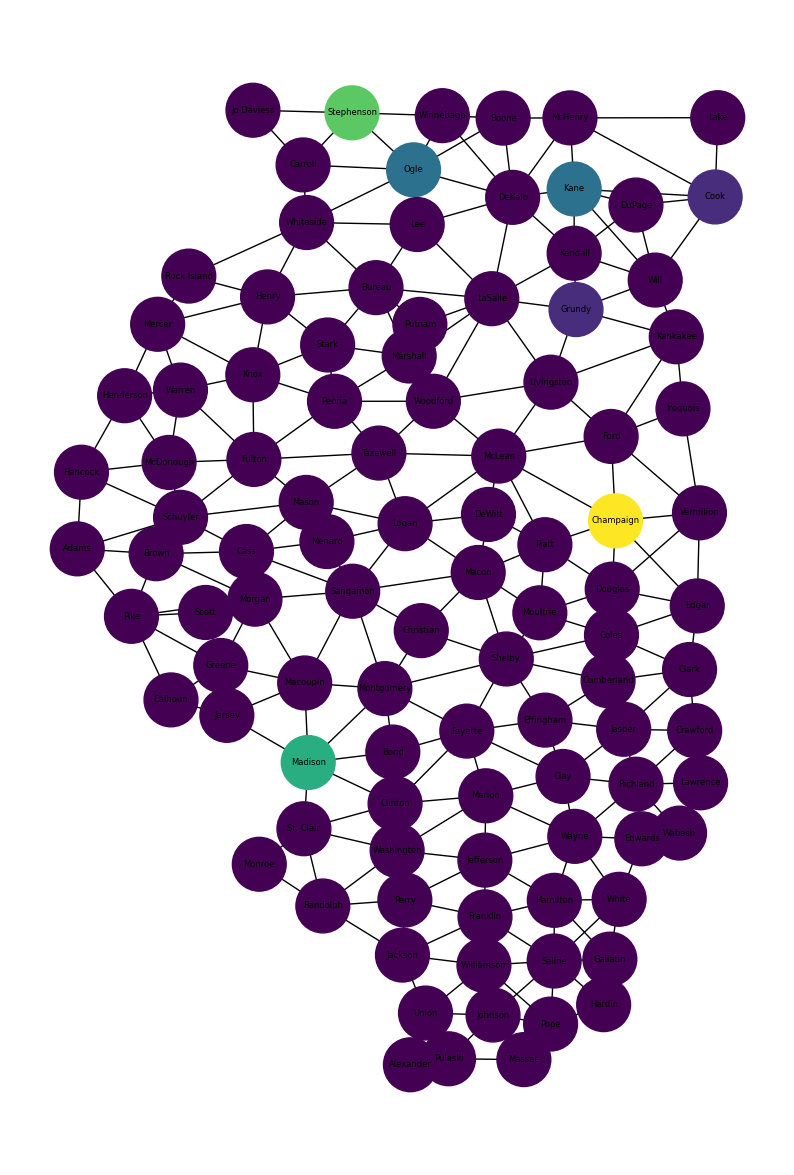

In [7]:
labels = {node: handler[node.name].name for node in CG.nodes()}
fig, ax = plt.subplots(figsize=(10, 15))
node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
nx.draw(CG, 
        pos=node_positions,
        ax=ax, 
        node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
        node_size=1500, )

nx.draw_networkx_labels(CG, pos=node_positions, labels=labels, font_size=6, ax=ax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])  # Creating an empty array as a workaround to add colorbar
# plt.colorbar(sm)

In [8]:
simulation_df['County'].values

array(['Cook', 'DuPage', 'Kane', 'Will', 'Winnebago', 'Lake', 'McHenry',
       'St. Clair', 'Kendall', 'Madison', 'Rock Island', 'Peoria',
       'Sangamon', 'Tazewell', 'Champaign', 'Boone', 'Macon', 'Kankakee',
       'DeKalb', 'Williamson', 'McLean', 'Grundy', 'Coles', 'Jackson',
       'LaSalle', 'Franklin', 'Vermilion', 'Monroe', 'Stephenson',
       'Whiteside', 'Adams', 'Clinton', 'Knox', 'Woodford', 'Effingham',
       'Ogle', 'Marion', 'Jefferson', 'Saline', 'Massac', 'Morgan',
       'Henry', 'Jersey', 'Randolph', 'McDonough', 'Macoupin', 'Wabash',
       'Perry', 'Logan', 'Lee', 'Christian', 'Douglas', 'Bond',
       'Lawrence', 'Richland', 'Crawford', 'Moultrie', 'Montgomery',
       'Union', 'Fulton', 'DeWitt', 'Menard', 'Bureau', 'Piatt',
       'Livingston', 'Johnson', 'Jo Daviess', 'Cass', 'Putnam', 'Warren',
       'Carroll', 'Clark', 'Cumberland', 'Alexander', 'Marshall',
       'Fayette', 'Edwards', 'Pulaski', 'Clay', 'Edgar', 'White',
       'Shelby', 'Ford', 'Merc

In [9]:
for node in CG.nodes():
    print(node.name)

Cook
DuPage
Kane
Will
Winnebago
Lake
McHenry
St. Clair
Kendall
Madison
Rock Island
Peoria
Sangamon
Tazewell
Champaign
Boone
Macon
Kankakee
DeKalb
Williamson
McLean
Grundy
Coles
Jackson
LaSalle
Franklin
Vermilion
Monroe
Stephenson
Whiteside
Adams
Clinton
Knox
Woodford
Effingham
Ogle
Marion
Jefferson
Saline
Massac
Morgan
Henry
Jersey
Randolph
McDonough
Macoupin
Wabash
Perry
Logan
Lee
Christian
Douglas
Bond
Lawrence
Richland
Crawford
Moultrie
Montgomery
Union
Fulton
DeWitt
Menard
Bureau
Piatt
Livingston
Johnson
Jo Daviess
Cass
Putnam
Warren
Carroll
Clark
Cumberland
Alexander
Marshall
Fayette
Edwards
Pulaski
Clay
Edgar
White
Shelby
Ford
Mercer
Iroquois
Washington
Mason
Greene
Hardin
Wayne
Hancock
Brown
Scott
Stark
Jasper
Hamilton
Pike
Henderson
Calhoun
Schuyler
Gallatin
Pope
